In [ ]:
# !pip install -q -r requirements.txt
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict, load_dataset, Features, Value

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler
from torch.optim import AdamW, lr_scheduler
from transformers import get_scheduler
from tqdm import tqdm
from tqdm.notebook import tqdm
import evaluate
import numpy as np
from torch.nn import functional as F
from typing import Union
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pandas as pd
from collections import Counter
from dataset_class import *
from text_clean import *
from BertDataSet import *
from ToxicityModel import *
from utils import *
# from ToxicityModel import *
sns.set_style('whitegrid')

import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

violet = '#702b9d'
RANDOM_SEED = 1011

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

##### loading
---

In [5]:
train_path = '/scratch/' + os.environ.get("USER", "") + '/data/jigsaw_training'
val_path =  '/scratch/' + os.environ.get("USER", "") + '/data/jigsaw_validation'
training_file_path = os.path.join(train_path, 'train.csv')
validation_file_path = os.path.join(val_path, 'validation_data.csv')

###### **training**

In [5]:
toxicity_train = pd.read_csv(f'{training_file_path}')
toxicity_train['label'] = np.where(toxicity_train.target > 0.5, 1, 0)

count    1.804874e+06
mean     1.030173e-01
std      1.970757e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e-01
max      1.000000e+00
Name: target, dtype: float64


<AxesSubplot:xlabel='target', ylabel='Count'>

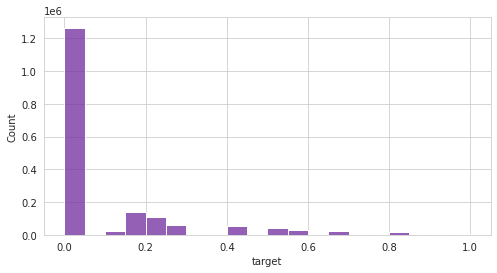

In [6]:
# take a look at distribution
print(toxicity_train.target.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(toxicity_train.target, binwidth = .05, color = violet, ax = ax)

###### **validation**

In [6]:
toxicity_valid = pd.read_csv(f'{validation_file_path}')
print(toxicity_valid.nunique())
print(toxicity_valid.shape)

worker          753
less_toxic    11532
more_toxic    11678
dtype: int64
(30108, 3)


In [11]:
## preprocess validation dataset 
texts = set(toxicity_valid.less_toxic.to_list() + toxicity_valid.more_toxic.to_list())
text2id = {t:id for id,t in enumerate(texts)}
toxicity_valid['less_id'] = toxicity_valid['less_toxic'].map(text2id)
toxicity_valid['more_id'] = toxicity_valid['more_toxic'].map(text2id)
toxicity_valid_grouped = (toxicity_valid.groupby(['less_id', 'more_id']).first()\
                          .reset_index().drop(['less_id', 'more_id'], axis = 1).drop(['worker'], axis = 1))
toxicity_valid_grouped.rename(columns = {'less_toxic':'less_toxic_text', 'more_toxic':'more_toxic_text'}, inplace = True)

In [12]:
toxicity_valid_grouped.to_csv(f'{val_path}/validation_grouped.csv')
toxicity_valid_grouped

,less_toxic_text,more_toxic_text
0,"Ossmann,are you jew or your father was an SS ...",its my talk page. keep the bitching off it. th...
1,"ROSES ARE RED, VIOLETS ARE BLUE, MAN I'M BLACK...","Actually I'm jewish too. But node is not, or a..."
2,An utter fabrication and ridiculous nonsense! ...,Russian transliteration\nDear Nixer. I am sor...
3,"""\n Nice straw man but you won't be able to hi...",I think there should be some form of screening...
4,"""\n Nice straw man but you won't be able to hi...",Let's get to fuckin big daddy ==\nMan I love s...
...,...,...
15405,Apparently you are not very clever as you thin...,But you are master of putting words into peop...
15406,Apparently you are not very clever as you thin...,"""\n\n What about \n[==Strasbourg==\nThis ? Rev..."
15407,go ahead \n\ni don't give a shit to that,FLOOD!!! COME AND DESTROY http://twitter.com/...
15408,Gonna fuck you up \n\nYou little bitch. 86.17...,unblock|unblock my restriction from editing yo...


In [7]:
## make new dataframe
toxic = toxic_dataset(df = toxicity_train, text = toxicity_train.comment_text, 
                      toxicity = toxicity_train.target, size = int(1e5//2), label = toxicity_train.label, seed = 1011)

toxic.make_dataframe(down_sample = True, make_pairs = True, threshold = 0.01)

toxicity_train_paired = toxic.df
toxicity_train_paired.to_csv(f'{train_path}/train_paired.csv')
toxic.df

paired up ...
made new dataframe ...


,more_toxic_text,less_toxic_text,toxicity_more_toxic,toxicity_less_toxic,labels_more_toxic,labels_less_toxic
0,To enjoy frustration and helplessness of Obama...,Well the issues of gender oppression & forced ...,0.166667,0.100000,0,0
1,"""Trudeau Liberals' national climate deal to ha...","The ""stoners"" don't really care, since they ca...",0.800000,0.200000,1,0
2,"Liberals are stupid, unskilled immigrants are ...",Most Catholics have no alternative to the Novu...,0.883333,0.200000,1,0
3,"As usual, Trump is right on.\n\nThink about it...",There's a couple of pretty big differences; an...,0.200000,0.111111,0,0
4,The amount of $$ sloshing around the pharmaceu...,God doesnt sort out details. War? Disease? ...,0.200000,0.100000,0,0
...,...,...,...,...,...,...
49995,"I have a ""Thank You for Being Stupid"" card to ...",Trump bites the hand that fed him like the ung...,0.833333,0.400000,1,0
49996,"Yeah, people like you like to parrot that phra...","So it sounds like a girl got in over her head,...",0.200000,0.166667,0,0
49997,"So nothing concrete to protest, they just do n...",And Obama appointed his basketball buddy. We s...,0.166667,0.166667,0,0
49998,I saw it on the news the night BEFORE his spee...,"Of course he isn't Mariota, but he's not Jonse...",0.166667,0.166667,0,0


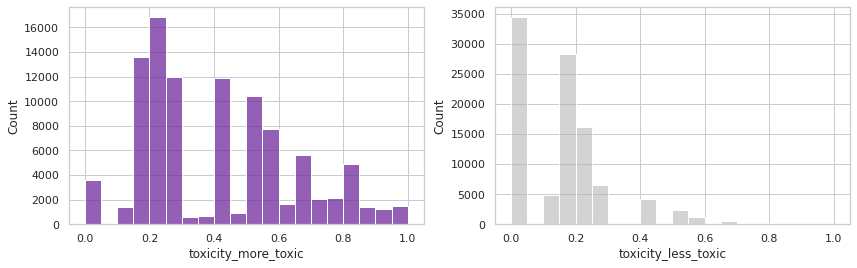

In [9]:
# take a look at distribution
fontsize = 12
fig, ax = plt.subplots(1,2, figsize = (14,4))
sns.set(style="whitegrid") 
sns.histplot(toxicity_train_paired.toxicity_more_toxic, binwidth = .05, 
             color = violet, ax = ax[0], label = 'more toxic')
sns.histplot(toxicity_train_paired.toxicity_less_toxic, binwidth = .05, 
             color = 'darkgray', alpha = 0.5, ax = ax[1], label = 'less toxic')
fig.savefig(f'{os.getcwd()}/output/paired_toxicity_dist.png', bbox_inches = 'tight', dpi = 300)

##### Text cleaning (optional)
---

In [8]:
## probably should be parallelized on GPU 
toxic.df.more_toxic_text = toxic.df.more_toxic_text.map(text_cleaning)
toxic.df.less_toxic_text = toxic.df.less_toxic_text.map(text_cleaning)

In [19]:
toxic.df.to_csv(f'{train_path}/train_paired_cleaned.csv')
toxic.df

,more_toxic_text,less_toxic_text,toxicity_more_toxic,toxicity_less_toxic,labels_more_toxic,labels_less_toxic
0,To enjoy frustration and helplessness of Obama...,Well the issues of gender oppression forced la...,0.166667,0.100000,0,0
1,Trudeau Liberals national climate deal to have...,The stoners don t really care since they can g...,0.800000,0.200000,1,0
2,Liberals are stupid unskilled immigrants are s...,Most Catholics have no alternative to the Novu...,0.883333,0.200000,1,0
3,As usual Trump is right on Think about it this...,There s a couple of pretty big differences and...,0.200000,0.111111,0,0
4,The amount of sloshing around the pharmaceutic...,God doesnt sort out details War Disease Storms...,0.200000,0.100000,0,0
...,...,...,...,...,...,...
49995,I have a Thank You for Being Stupid card to se...,Trump bites the hand that fed him like the ung...,0.833333,0.400000,1,0
49996,Yeah people like you like to parrot that phras...,So it sounds like a girl got in over her head ...,0.200000,0.166667,0,0
49997,So nothing concrete to protest they just do no...,And Obama appointed his basketball buddy We sa...,0.166667,0.166667,0,0
49998,I saw it on the news the night BEFORE his spee...,Of course he isn t Mariota but he s not Jonsen...,0.166667,0.166667,0,0


In [20]:
toxicity_valid_grouped.less_toxic_text = toxicity_valid_grouped.less_toxic_text.map(text_cleaning)
toxicity_valid_grouped.more_toxic_text = toxicity_valid_grouped.more_toxic_text.map(text_cleaning)
toxicity_valid_grouped.to_csv(f'{val_path}/val_cleaned.csv')

##### Prepare data for Datasets (optional)
---

In [5]:
# add dummy labels to validation set
train_set, val_set = 'train_paired_cleaned.csv', 'val_cleaned.csv' 
val_dataset = pd.read_csv(os.path.join(val_path, val_set))

val_dataset['labels_more_toxic'] = -1
val_dataset['labels_less_toxic'] = -1
val_dataset.to_csv(f'{val_path}/val_cleaned.csv')

train_dataset = load_dataset('csv', data_files = os.path.join(train_path, train_set))
val_dataset = load_dataset('csv', data_files = {'test': os.path.join(val_path, val_set)})

##### Debug do_train
---

In [6]:
train_tokenized_dataset = BERTDataset(
    more_toxic=train_dataset["train"]["more_toxic_text"],
    less_toxic=train_dataset["train"]["less_toxic_text"],
    labels_more_toxic=train_dataset["train"]["labels_more_toxic"],
    labels_less_toxic=train_dataset["train"]["labels_less_toxic"],
)

val_tokenized_dataset = BERTDataset(
    more_toxic=val_dataset["test"]["more_toxic_text"],
    less_toxic=val_dataset["test"]["less_toxic_text"],
    labels_more_toxic=val_dataset["test"]["labels_more_toxic"],
    labels_less_toxic=val_dataset["test"]["labels_less_toxic"],
)


In [7]:
def small_data_set(dataset, split, size = 100):
    rng = np.random.default_rng(seed = RANDOM_SEED)
    small_set = [dataset[split][int(i)] for i in rng.integers(0, len(dataset[split]), size = size)]
    small_dataset = Dataset.from_list(small_set)
    return small_dataset

In [8]:
small_train_dataset = small_data_set(train_dataset, 'train', size = 10000)
small_train_tokenized = BERTDataset(more_toxic=small_train_dataset['more_toxic_text'],
                                      less_toxic= small_train_dataset['less_toxic_text'],
                                      labels_more_toxic= small_train_dataset['labels_more_toxic'],
                                      labels_less_toxic= small_train_dataset['labels_less_toxic'],)

In [8]:
train_dataloader = DataLoader(small_train_tokenized, shuffle=True, num_workers = os.cpu_count(), batch_size= 8)
# val_dataloader = DataLoader(val_tokenized_dataset, shuffle=True, num_workers = os.cpu_count(), batch_size= 8)

In [48]:
# do_train(model, train_dataloader)

  0%|          | 0/2 [00:00<?, ?it/s]

0
1
Training completed...
Saving Model....


##### Read results
---

In [6]:
sub_path = ['/out_amended/', '/out_butter_homo_amended/', '/out_back/']

###### original

In [7]:
## original
path = '/scratch/' + os.environ.get("USER", "") + sub_path[0]
with open(os.path.join(path, 'train_loss_tracker.pkl'), 'rb') as f:
    train_original_loss = pickle.load(f)
f.close()

with open(os.path.join(path, 'train_metrics.pkl'), 'rb') as f:
    train_original_metrics = pickle.load(f)
f.close()

with open(os.path.join(path, 'eval_loss_tracker.pkl'), 'rb') as f:
    eval_original_loss = pickle.load(f)
f.close()

with open(os.path.join(path, 'eval_metrics.pkl'), 'rb') as f:
    eval_original_metrics = pickle.load(f)
f.close()

In [8]:
eval_original_metrics

{'accuracy': 0.5948734587929916}

In [9]:
train_original_metrics

{'accuracy': {'accuracy': 0.64566}, 'roc_auc': {'roc_auc': 0.7580781488372195}}

In [10]:
## confidence, predictions, labels
path = '/scratch/' + os.environ.get("USER", "") + sub_path[0]
ECE_original = pd.read_csv(os.path.join(path, 'ECE_original.txt'), sep = '\t')
ECE_original = map_results(ECE_original, cols = ECE_original.columns)

In [11]:
path = '/scratch/' + os.environ.get("USER", "") + sub_path[0]
with open(os.path.join(path, 'eval_loss_tracker.pkl'), 'rb') as f:
    eval_original_loss = pickle.load(f)
f.close()

###### butter_homo

In [12]:
## butterfinger
path = '/scratch/' + os.environ.get("USER", "") + sub_path[1]
with open(os.path.join(path, 'train_loss_tracker.pkl'), 'rb') as f:
    train_butter_loss = pickle.load(f)
f.close()

with open(os.path.join(path, 'train_metrics.pkl'), 'rb') as f:
    train_butter_metrics = pickle.load(f)
f.close()

with open(os.path.join(path, 'eval_loss_tracker.pkl'), 'rb') as f:
    eval_butter_loss = pickle.load(f)
f.close()

with open(os.path.join(path, 'eval_metrics.pkl'), 'rb') as f:
    eval_butter_metrics = pickle.load(f)
f.close()

In [13]:
train_butter_metrics

{'accuracy': {'accuracy': 0.6469527777777778},
 'roc_auc': {'roc_auc': 0.7610766281799295}}

In [14]:
eval_butter_metrics

{'accuracy': 0.591109669046074}

In [15]:
## confidence, predictions, labels
path = '/scratch/' + os.environ.get("USER", "") + sub_path[1]
ECE_butter_homo = pd.read_csv(os.path.join(path, 'ECE_butter_homo.txt'), sep = '\t')
ECE_butter_homo = map_results(ECE_butter_homo, cols = ECE_butter_homo.columns)

In [16]:
path = '/scratch/' + os.environ.get("USER", "") + sub_path[1]
with open(os.path.join(path, 'eval_loss_tracker.pkl'), 'rb') as f:
    eval_butter_loss = pickle.load(f)
f.close()

###### back_trans

In [17]:
## back translation
path = '/scratch/' + os.environ.get("USER", "") + sub_path[-1]
with open(os.path.join(path, 'train_loss_tracker.pkl'), 'rb') as f:
    train_back_loss = pickle.load(f)
f.close()

with open(os.path.join(path, 'train_metrics.pkl'), 'rb') as f:
    train_back_metrics = pickle.load(f)
f.close()

with open(os.path.join(path, 'eval_loss_tracker.pkl'), 'rb') as f:
    eval_back_loss = pickle.load(f)
f.close()

with open(os.path.join(path, 'eval_metrics.pkl'), 'rb') as f:
    eval_back_metrics = pickle.load(f)
f.close()

In [18]:
eval_back_metrics

{'accuracy': 0.5940298507462687}

In [19]:
train_back_metrics

{'accuracy': {'accuracy': 0.6554515151515151},
 'roc_auc': {'roc_auc': 0.7630611223713107}}

In [20]:
## confidence, predictions, labels
path = '/scratch/' + os.environ.get("USER", "") + sub_path[-1]
ECE_back = pd.read_csv(os.path.join(path, 'ECE_back_translation.txt'), sep = '\t')
ECE_back = map_results(ECE_back, cols = ECE_back.columns)

In [21]:
path = '/scratch/' + os.environ.get("USER", "") + sub_path[-1]
with open(os.path.join(path, 'eval_loss_tracker.pkl'), 'rb') as f:
    eval_back_loss = pickle.load(f)
f.close()

##### Plot
---

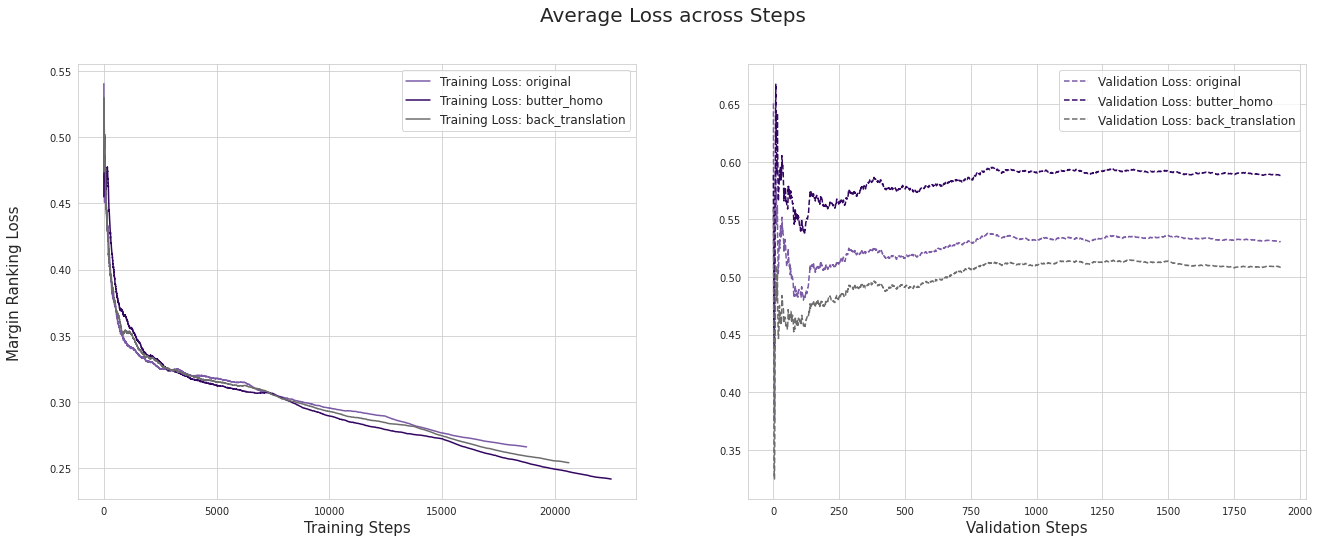

In [21]:
import matplotlib.pyplot as plt
## loss from utils
plot_loss([train_original_loss, train_butter_loss, train_back_loss, 
           eval_original_loss, eval_butter_loss, eval_back_loss])

In [22]:
## ECE loss 
## credit: from https://github.com/nyu-cs2590/course-material/blob/gh-pages/fall2023/section/sec08/sec08.ipynb
class ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).

    The input to this loss is the logits of a model, NOT the softmax scores.

    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:

    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |

    We then return a weighted average of the gaps, based on the number
    of samples in each bin

    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, confidences, predictions, labels):
        self.bin_list = []
        self.avg_confidence_in_bin_list = []
        self.accuracy_in_bin_list = []
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            else:
                accuracy_in_bin = -100
                avg_confidence_in_bin = -100
            self.bin_list.append([bin_lower.item(),bin_upper.item()])
            self.avg_confidence_in_bin_list.append(avg_confidence_in_bin)
            self.accuracy_in_bin_list.append(accuracy_in_bin)            
        return ece

In [23]:
## ECE on training set (original)
ECE_loss = ECELoss()
conf_tensor = torch.FloatTensor(ECE_original.Confidence.explode().to_list())
pred_tensor = torch.FloatTensor(ECE_original.Prediction.explode().to_list())
label_tensor = torch.FloatTensor(ECE_original.Label.explode().to_list())

ECE_loss(conf_tensor, pred_tensor, label_tensor)

tensor([0.1131])

In [24]:
confidence_arr = torch.tensor(list(map(lambda x: x if x >= 0 else 0, ECE_loss.avg_confidence_in_bin_list)))
accuracy_arr = torch.tensor(list(map(lambda x: x if x >= 0 else 0, ECE_loss.accuracy_in_bin_list)))

print(f"confidence: {confidence_arr}")
print(f"accuracy  : {accuracy_arr}")

bins_interval = np.array(ECE_loss.bin_list)
bins = bins_interval.mean(axis=-1)

confidence: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5165, 0.5668,
        0.6336, 0.7002, 0.7674, 0.8337, 0.9003, 0.9612])
accuracy  : tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5084, 0.5275,
        0.5518, 0.5841, 0.6219, 0.6774, 0.7491, 0.8346])


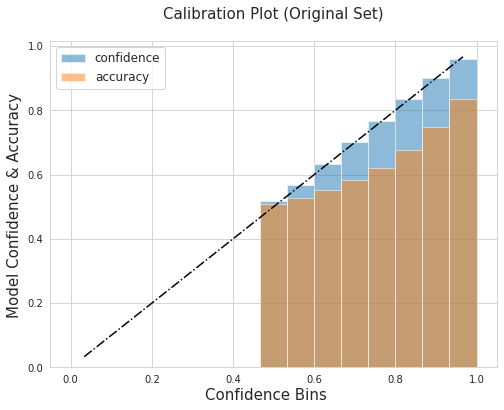

In [25]:
fig, ax = plt.subplots(1,1, figsize= (8,6))
ax.bar(bins, np.array(confidence_arr), width=np.mean(bins_interval[:,1]-bins_interval[:,0]), alpha=0.5, label='confidence')
ax.bar(bins, np.array(accuracy_arr), width=np.mean(bins_interval[:,1]-bins_interval[:,0]), alpha=0.5, label='accuracy')
ax.plot(bins, bins, '-.',color='black')
y_label = fig.text(0.05, 0.5, "Model Confidence & Accuracy", va='center', rotation='vertical', fontsize=15)
x_label = fig.text(0.5, 0.05, "Confidence Bins", ha = 'center', fontsize = 15)
ax.legend(fontsize = 12)
ax.set_title('Calibration Plot (Original Set)', fontsize = 15, y = 1.05)
plt.show()

save_path = '/scratch/tl2546/NLP_project/BERT/output'
fig.savefig(f'{save_path}/calibration_original.png', dpi = 500, bbox_inches = 'tight')

In [26]:
## ECE on butter finger
ECE_loss = ECELoss()
conf_tensor = torch.FloatTensor(ECE_butter_homo.Confidence.explode().to_list())
pred_tensor = torch.FloatTensor(ECE_butter_homo.Prediction.explode().to_list())
label_tensor = torch.FloatTensor(ECE_butter_homo.Label.explode().to_list())

ECE_loss(conf_tensor, pred_tensor, label_tensor)

tensor([0.1249])

confidence: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5168, 0.5669,
        0.6335, 0.7003, 0.7673, 0.8340, 0.9010, 0.9640])
accuracy  : tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5127, 0.5235,
        0.5457, 0.5787, 0.6197, 0.6647, 0.7296, 0.8202])


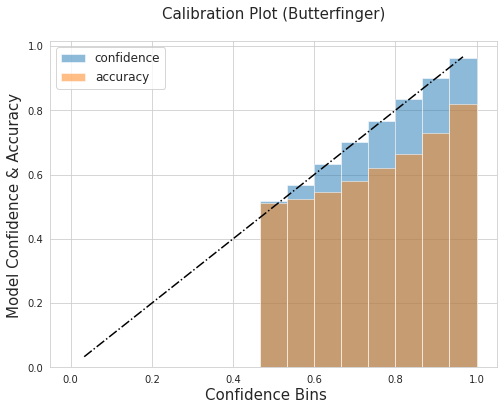

In [27]:
confidence_arr = torch.tensor(list(map(lambda x: x if x >= 0 else 0, ECE_loss.avg_confidence_in_bin_list)))
accuracy_arr = torch.tensor(list(map(lambda x: x if x >= 0 else 0, ECE_loss.accuracy_in_bin_list)))

print(f"confidence: {confidence_arr}")
print(f"accuracy  : {accuracy_arr}")

bins_interval = np.array(ECE_loss.bin_list)
bins = bins_interval.mean(axis=-1)

fig, ax = plt.subplots(1,1, figsize= (8,6))
ax.bar(bins, np.array(confidence_arr), width=np.mean(bins_interval[:,1]-bins_interval[:,0]), alpha=0.5, label='confidence')
ax.bar(bins, np.array(accuracy_arr), width=np.mean(bins_interval[:,1]-bins_interval[:,0]), alpha=0.5, label='accuracy')
ax.plot(bins, bins, '-.',color='black')
y_label = fig.text(0.05, 0.5, "Model Confidence & Accuracy", va='center', rotation='vertical', fontsize=15)
x_label = fig.text(0.5, 0.05, "Confidence Bins", ha = 'center', fontsize = 15)
ax.legend(fontsize = 12)
ax.set_title('Calibration Plot (Butterfinger)', fontsize = 15, y = 1.05)
plt.show()

save_path = '/scratch/tl2546/NLP_project/BERT/output'
fig.savefig(f'{save_path}/calibration_butterfinger.png', dpi = 500, bbox_inches = 'tight')

In [28]:
## ECE on back translation
ECE_loss = ECELoss()
conf_tensor = torch.FloatTensor(ECE_back.Confidence.explode().to_list())
pred_tensor = torch.FloatTensor(ECE_back.Prediction.explode().to_list())
label_tensor = torch.FloatTensor(ECE_back.Label.explode().to_list())

ECE_loss(conf_tensor, pred_tensor, label_tensor)

tensor([0.1123])

confidence: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5166, 0.5669,
        0.6337, 0.7003, 0.7672, 0.8339, 0.9005, 0.9637])
accuracy  : tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5021, 0.5262,
        0.5573, 0.5898, 0.6332, 0.6839, 0.7523, 0.8295])


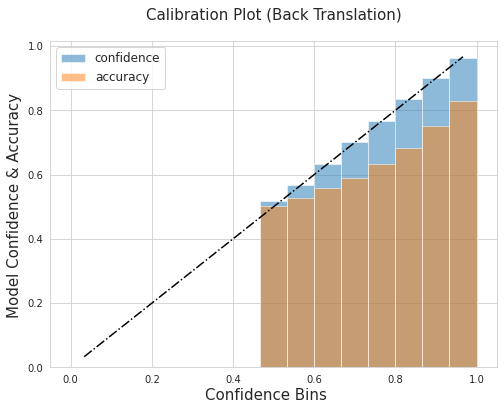

In [29]:
confidence_arr = torch.tensor(list(map(lambda x: x if x >= 0 else 0, ECE_loss.avg_confidence_in_bin_list)))
accuracy_arr = torch.tensor(list(map(lambda x: x if x >= 0 else 0, ECE_loss.accuracy_in_bin_list)))

print(f"confidence: {confidence_arr}")
print(f"accuracy  : {accuracy_arr}")

bins_interval = np.array(ECE_loss.bin_list)
bins = bins_interval.mean(axis=-1)

fig, ax = plt.subplots(1,1, figsize= (8,6))
ax.bar(bins, np.array(confidence_arr), width=np.mean(bins_interval[:,1]-bins_interval[:,0]), alpha=0.5, label='confidence')
ax.bar(bins, np.array(accuracy_arr), width=np.mean(bins_interval[:,1]-bins_interval[:,0]), alpha=0.5, label='accuracy')
ax.plot(bins, bins, '-.',color='black')
y_label = fig.text(0.05, 0.5, "Model Confidence & Accuracy", va='center', rotation='vertical', fontsize=15)
x_label = fig.text(0.5, 0.05, "Confidence Bins", ha = 'center', fontsize = 15)
ax.legend(fontsize = 12)
ax.set_title('Calibration Plot (Back Translation)', fontsize = 15, y = 1.05)
plt.show()

save_path = '/scratch/tl2546/NLP_project/BERT/output'
fig.savefig(f'{save_path}/calibration_back.png', dpi = 500, bbox_inches = 'tight')

##### Failed Trials
---

In [ ]:
# take a look at distribution
print(toxicity_train.severe_toxicity.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(toxicity_train.severe_toxicity, binwidth = .05, color = violet, ax = ax)


In [ ]:
train_jtc = pd.read_csv(f'{os.path.join(train_path, "train_jtc.csv")}')
train_jtc.nunique()

In [ ]:
# take a look at distribution
print(train_jtc.toxic.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(train_jtc.toxic, binwidth = .05, color = violet, ax = ax)

In [ ]:
# no need to use with json

train_set_features = Features(
    {
        "more_toxic_text": Value("string"),
        "less_toxic_text": Value("string"),
        "toxicity_more_toxic": Value("float64"),
        "toxicity_less_toxic": Value("float64"),
        "labels_more_toxic": Value("int64"),
        "labels_less_toxic": Value("int64"),
    }
)

val_set_features = Features(
    {
        "more_toxic_text": Value("string"),
        "less_toxic_text": Value("string")}
)

In [13]:
train_set, val_set = 'jigsaw_training/train_paired_cleaned.json', 'jigsaw_validation/val_cleaned.json' 

train_to_load = DatasetDict.from_json({'train': os.path.join(data_path, train_set)})
val_to_load = DatasetDict.from_json({'test':os.path.join(data_path, val_set)})

combined_dataset_dict = DatasetDict()
combined_dataset_dict['train'] = train_to_load['train']
combined_dataset_dict['val'] = val_to_load['test']

combined_dataset_dict.save_to_disk(data_path)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

In [10]:
os.chdir('/scratch/tl2546/NLP_project/')
!pwd

/scratch/tl2546/NLP_project


In [ ]:
small_train_aug = small_train_dataset.map(custom_transform)

In [6]:
train_to_load = pd.read_json(f'{train_path}/train_paired_cleaned.json')
val_to_load = pd.read_json(f'{val_path}/val_cleaned.json')

data_path =  '/scratch/' + os.environ.get("USER", "") + '/data/'
train_set, val_set = 'jigsaw_training/train_paired_cleaned.json', 'jigsaw_validation/val_cleaned.json' 

- small set

In [4]:
sub_path_small = ['/out_small_original/', '/out_small_butter/', '/out_small_back_trans/']

In [5]:
## original
path = '/scratch/' + os.environ.get("USER", "") + sub_path_small[0]
with open(os.path.join(path, 'eval_loss_tracker.pkl'), 'rb') as f:
    eval_original_loss = pickle.load(f)
f.close()

with open(os.path.join(path, 'eval_metrics.pkl'), 'rb') as f:
    eval_original_metrics = pickle.load(f)
f.close()

## butterfinger
path = '/scratch/' + os.environ.get("USER", "") + sub_path_small[1]
with open(os.path.join(path, 'eval_loss_tracker.pkl'), 'rb') as f:
    eval_butter_loss = pickle.load(f)
f.close()

with open(os.path.join(path, 'eval_metrics.pkl'), 'rb') as f:
    eval_butter_metrics = pickle.load(f)
f.close()

## back translation
path = '/scratch/' + os.environ.get("USER", "") + sub_path_small[-1]
with open(os.path.join(path, 'eval_loss_tracker.pkl'), 'rb') as f:
    eval_back_loss = pickle.load(f)
f.close()

with open(os.path.join(path, 'eval_metrics.pkl'), 'rb') as f:
    eval_back_metrics = pickle.load(f)
f.close()

- plot

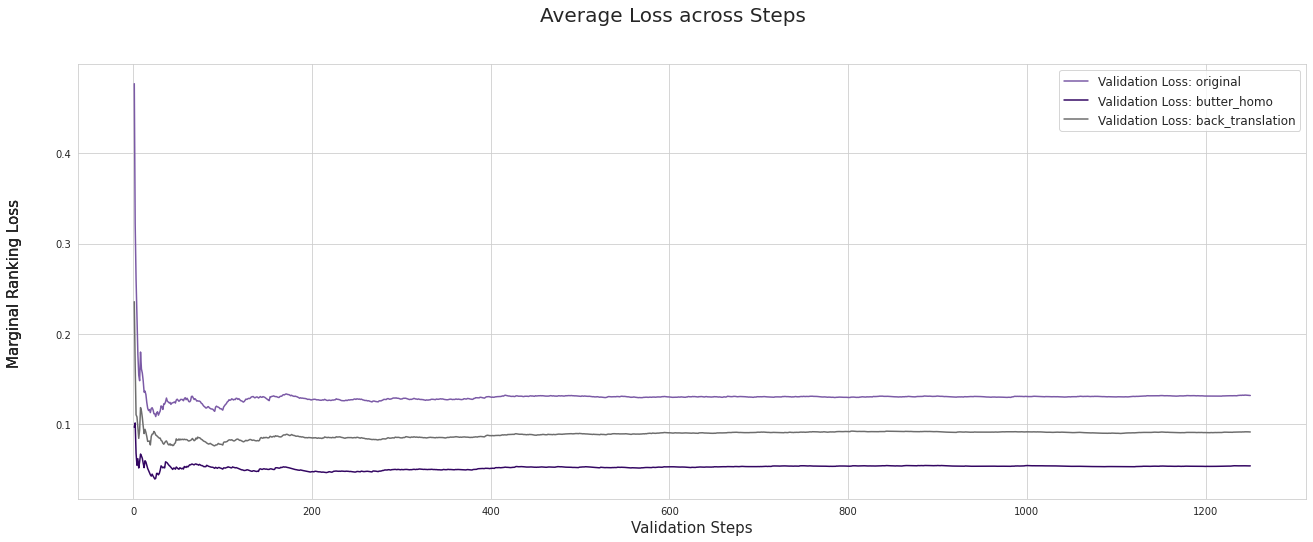

In [14]:
fig, ax = plt.subplots(1,1, figsize = (22,8))
nyu_colors = ['#7b5aa6', '#330662', '#6d6d6d']
line_style = ['-', '--']
data_set = ['Validation', 'Training']
aug_type = ['original', 'butter_homo', 'back_translation']
total = 3


for i, loss_tracker in enumerate([eval_original_loss, eval_butter_loss, eval_back_loss]):
    sns.lineplot(x = range(1, len(loss_tracker['avg']) + 1), y = loss_tracker['avg'], 
                     label=f'{data_set[i//total]} Loss: {aug_type[i%total]}', color = nyu_colors[i%total], 
                     linestyle = line_style[i//total], lw = 1.5, ax = ax)
    ax.set_xlabel(f'{data_set[i//total]} Steps', fontsize = 15)
    ax.legend(fontsize = 12)
    fig.suptitle('Average Loss across Steps', fontsize=20)
    y_label = fig.text(0.08, 0.5, 'Marginal Ranking Loss', va='center', rotation='vertical', fontsize=15)
    save_path = '/scratch/tl2546/NLP_project/BERT/output'
    fig.savefig(f'{save_path}/MRL_plot_small.png', dpi = 500, bbox_inches = 'tight')